In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import datetime
import re

import lightgbm as lgb
import xgboost as xgb
sns.set()

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
data = pd.read_csv('train.csv',low_memory=False)

In [17]:
cat_vars = data.select_dtypes(include='object').columns; cat_vars
cont_vars = data.select_dtypes(exclude='object').columns; cont_vars

for col in cont_vars:
    data[col] = data[col].fillna(data[col].median())
    
for col in cat_vars:
    data[col] = data[col].fillna('Missing')
    
from sklearn.preprocessing import LabelEncoder
for col in cat_vars:
    le = LabelEncoder()
    le.fit(data[col])
    data[col] = le.transform(data[col])
#     test[col] = le.transform(list(test[col].astype(str).values))   

from sklearn.metrics import *

crps_scores = []
def train_model(X, y, folds, model_type='lgb', eval_metric='auc', n_jobs=-1, n_estimators=None, plot_feature_importance=True, verbose=500,early_stopping_rounds=200):
    result_dict = {}
    scores = []
    n_splits = folds.n_splits
    columns = X.columns
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), 1))
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y,X['GameId'])):
        print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model = lgb.LGBMRegressor(n_estimators=n_estimators, n_jobs = n_jobs)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_absolute_error(y_valid, y_pred))
        oof[valid_index] = y_pred.reshape(-1, 1)
        print(len(y_train))
        print(y_pred.shape)
        y_pred_crps = np.zeros((len(y_pred),199))
        y_ans = np.zeros((len(y_pred),199))

        for i,p in enumerate(y_pred):
            p+=99
            for j in range(199):
                if j>=p+10:
                    y_pred_crps[i][j]=1.0
                elif j>=p-10:
                    y_pred_crps[i][j]=(j+10-p)*0.05


        for i,p in enumerate(y_valid):
            try:
                p+=99
                for j in range(199):
                    if j>=p:
                        y_ans[i][j]=1.0
            except:
                print(i,j)
                raise Exception
        crps = np.sum(np.power(y_pred_crps-y_ans,2))/(199*(509762//22))
        print("CRPS validation score:",crps)
        crps_scores.append(crps)
        scores.append(rmse)
    
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print('CRPS avg',np.mean(crps_scores))
    result_dict['oof'] = oof
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].reset_index(level=['feature'])


            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features);
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict

In [18]:
rushers = data[data.NflId==data.NflIdRusher]

Fold nr 0
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's l1: 3.4466	training's l2: 33.711	valid_1's l1: 3.51126	valid_1's l2: 35.4904
18520
(4651,)
CRPS validation score: 0.0029680665239500215
Fold nr 1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's l1: 3.35801	training's l2: 31.6609	valid_1's l1: 3.64346	valid_1's l2: 37.9818
18521
(4650,)
CRPS validation score: 0.0030484173310824877
Fold nr 2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's l1: 3.42819	training's l2: 33.1868	valid_1's l1: 3.69008	valid_1's l2: 41.0345
18547
(4624,)
CRPS validation score: 0.003088382937046848
Fold nr 3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's l1: 3.37718	training's l2: 31.4053	valid_1's l1: 3.6905	valid_1's l2: 41.6118
18548
(4623,)
CRPS 

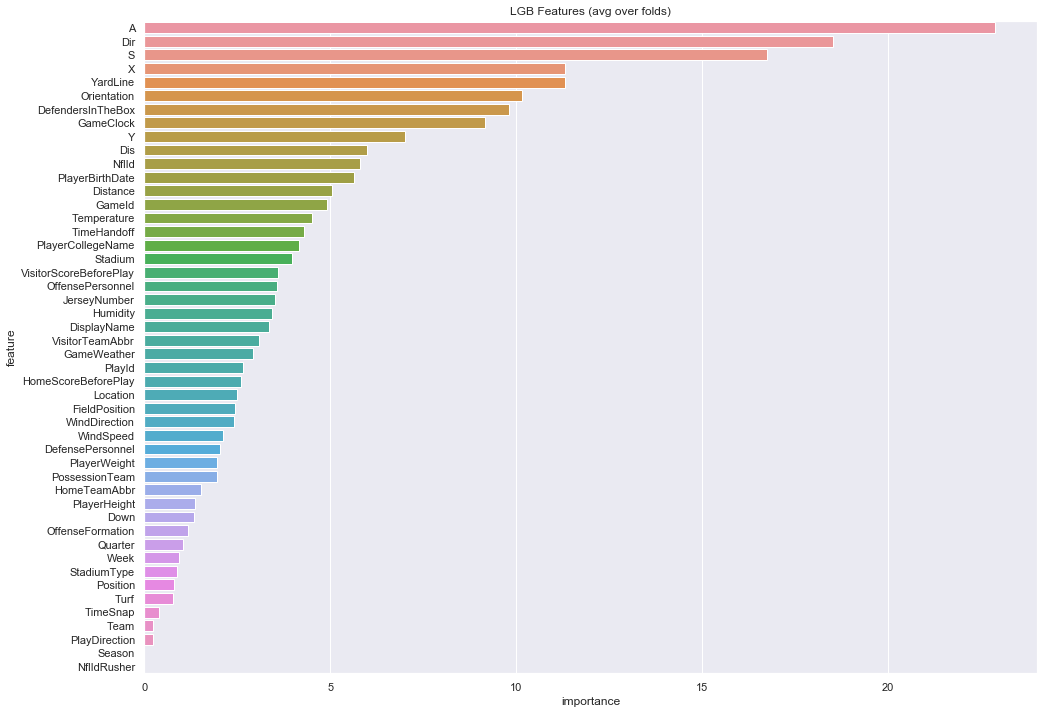

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
X = rushers.drop(['Yards'],axis=1)
y = rushers['Yards']
folds = GroupKFold(n_splits=5)
results = train_model(X, y, folds, n_estimators=1000) # a, s, clos, dirstd,gamecloc, dir,orient, x, time

In [16]:
np.mean(crps_scores)

0.0030309183028358194